### Uczenie maszynowe
# 4. Regresja logistyczna

**Uwaga**: Wbrew nazwie, *regresja* logistyczna jest algorytmem służącym do rozwiązywania problemów *klasyfikacji* (wcale nie problemów *regresji*!)

Do demonstracji metody regresji ligistycznej wykorzystamy klasyczny zbiór danych <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">*Iris flower data set*</a>, składający się ze 150 przykładów wartości 4 cech dla 3 gatunków irysów (kosaćców).

### *Iris flower data set*

* 150 przykładów
* 4 cechy
* 3 kategorie

| <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Kosaciec_szczecinkowaty_Iris_setosa.jpg/450px-Kosaciec_szczecinkowaty_Iris_setosa.jpg"> | <img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/736px-Iris_virginica.jpg"> | <img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/Blue_Flag%2C_Ottawa.jpg/600px-Blue_Flag%2C_Ottawa.jpg"> |
| :--- | :--- | :--- |
| *Iris setosa* | *Iris virginica* | *Iris versicolor* |
| kosaciec szczecinkowy | kosaciec amerykański | kosaciec różnobarwny |


4 cechy:
 * długość działek kielicha (*sepal length*, `sl`)
 * szerokość działek kielicha (*sepal width*, `sw`)
 * długość płatka (*petal length*, `pl`)
 * szerokość płatka (*petal width*, `pw`)

## 4.1. Dwuklasowa regresja logistyczna

Zacznijmy od najprostszego przypadku:
 * ograniczmy się do **2** klas
 * ograniczmy się do **1** zmiennej

→ dwuklasowa regresja logistyczna jednej zmiennej

In [1]:
# Przydatne importy

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas
import ipywidgets as widgets

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython.display import display, Math, Latex

# Przydatne funkcje

def LatexMatrix(matrix):
    """Wyświetlanie macierzy w LaTeX-u"""
    ltx = r'\left[\begin{array}'
    m, n = matrix.shape
    ltx += '{' + ("r" * n) + '}'
    for i in range(m):
        ltx += r" & ".join([('%.4f' % j.item()) for j in matrix[i]]) + r" \\ "
    ltx += r'\end{array}\right]'
    return ltx

def h(theta, X):
    """Hipoteza (wersja macierzowa)"""
    return X * theta

def regdots(X, y, xlabel, ylabel):
    """Wykres danych (wersja macierzowa)"""
    fig = plt.figure(figsize=(16*.6, 9*.6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)
    ax.scatter([X[:, 1]], [y], c='r', s=50, label='Dane')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.margins(.05, .05)
    plt.ylim(y.min() - 1, y.max() + 1)
    plt.xlim(np.min(X[:, 1]) - 1, np.max(X[:, 1]) + 1)
    return fig

def regline(fig, fun, theta, X):
    """Wykres krzywej regresji (wersja macierzowa)"""
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    L = [x0, x1]
    LX = np.matrix([1, x0, 1, x1]).reshape(2, 2)
    ax.plot(L, fun(theta, LX), linewidth='2',
            label=(r'$y={theta0:.2}{op}{theta1:.2}x$'.format(
                theta0=float(theta[0][0]),
                theta1=(float(theta[1][0]) if theta[1][0] >= 0 else float(-theta[1][0])),
                op='+' if theta[1][0] >= 0 else '-')))

def legend(fig):
    """Legenda wykresu"""
    ax = fig.axes[0]
    handles, labels = ax.get_legend_handles_labels()
    # try-except block is a fix for a bug in Poly3DCollection
    try:
        fig.legend(handles, labels, fontsize='15', loc='lower right')
    except AttributeError:
        pass

def J(theta,X,y):
    """Wersja macierzowa funkcji kosztu"""
    m = len(y)
    J = 1.0 / (2.0 * m) * ((X * theta - y).T * ( X * theta - y))
    return J.item()

def dJ(theta,X,y):
    """Wersja macierzowa gradientu funkcji kosztu"""
    return 1.0 / len(y) * (X.T * (X * theta - y)) 

def GD(fJ, fdJ, theta, X, y, alpha=0.1, eps=10**-3):
    """Implementacja algorytmu gradientu prostego za pomocą numpy i macierzy"""
    current_cost = fJ(theta, X, y)
    while True:
        theta = theta - alpha * fdJ(theta, X, y) # implementacja wzoru
        current_cost, prev_cost = fJ(theta, X, y), current_cost
        if current_cost > 10000:
            break
        if abs(prev_cost - current_cost) <= eps:
            break
    return theta

theta_start = np.matrix([0, 0]).reshape(2, 1)

def threshold(fig, theta):
    """Funkcja, która rysuje próg"""
    x_thr = (0.5 - theta.item(0)) / theta.item(1)
    ax = fig.axes[0]
    ax.plot([x_thr, x_thr], [-1, 2],
            color='orange', linestyle='dashed',
            label=u'próg: $x={:.2F}$'.format(x_thr))

In [2]:
# Wczytanie pełnych (oryginalnych) danych

data_iris = pandas.read_csv("iris.csv")
print(data_iris[:6])


    sl   sw   pl   pw          Gatunek
0  5.2  3.4  1.4  0.2      Iris-setosa
1  5.1  3.7  1.5  0.4      Iris-setosa
2  6.7  3.1  5.6  2.4   Iris-virginica
3  6.5  3.2  5.1  2.0   Iris-virginica
4  4.9  2.5  4.5  1.7   Iris-virginica
5  6.0  2.7  5.1  1.6  Iris-versicolor


In [3]:
# Ograniczenie danych do 2 klas i 1 cechy

data_iris_setosa = pandas.DataFrame()
data_iris_setosa["dł. płatka"] = data_iris["pl"]  # "pl" oznacza "petal length"
data_iris_setosa["Iris setosa?"] = data_iris["Gatunek"].apply(
    lambda x: 1 if x == "Iris-setosa" else 0
)
print(data_iris_setosa[:6])


   dł. płatka  Iris setosa?
0         1.4             1
1         1.5             1
2         5.6             0
3         5.1             0
4         4.5             0
5         5.1             0


In [4]:
import numpy as np

# Przygotowanie danych
m, n_plus_1 = data_iris_setosa.values.shape
n = n_plus_1 - 1
Xn = data_iris_setosa.values[:, 0:n].reshape(m, n)

X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
y = np.matrix(data_iris_setosa.values[:, 1]).reshape(m, 1)

# Regresja liniowa
theta_lin = GD(J, dJ, theta_start, X, y, alpha=0.03, eps=0.000001)


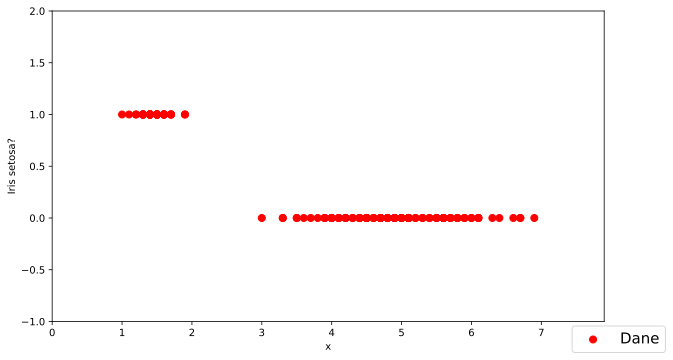

In [5]:
fig = regdots(X, y, "x", "Iris setosa?")
legend(fig)


#### Próba zastosowania regresji liniowej do problemu klasyfikacji

Najpierw z ciekawości sprawdźmy, co otrzymalibyśmy, gdybyśmy zastosowali regresję liniową do problemu klasyfikacji.

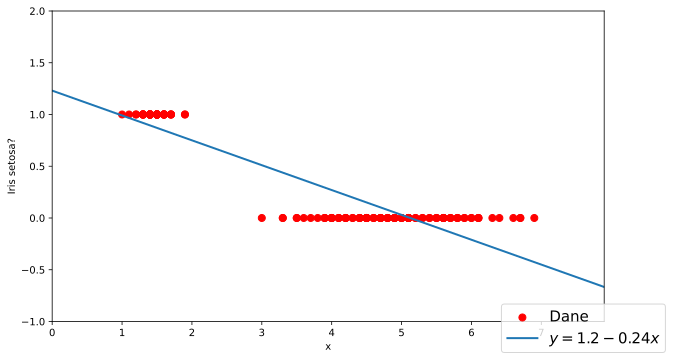

In [6]:
fig = regdots(X, y, "x", "Iris setosa?")
regline(fig, h, theta_lin, X)
legend(fig)


A gdyby tak przyjąć, że klasyfikator zwraca $1$ dla $h(x) > 0.5$ i $0$ w przeciwnym przypadku?

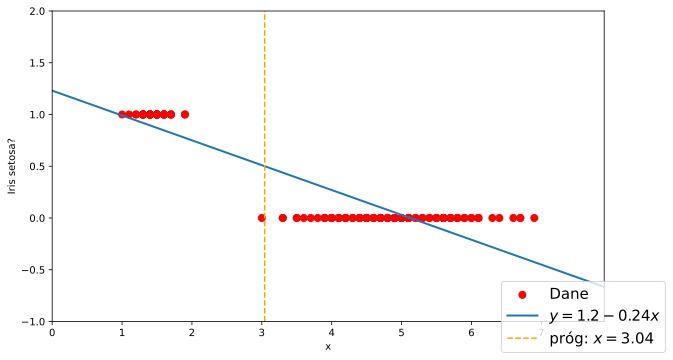

In [7]:
fig = regdots(X, y, "x", "Iris setosa?")
theta_lin = GD(J, dJ, theta_start, X, y, alpha=0.03, eps=0.000001)
regline(fig, h, theta_lin, X)
threshold(
    fig, theta_lin
)  # pomarańczowa linia oznacza granicę między klasą "1" a klasą "0" wyznaczoną przez próg "h(x) = 0.5"
legend(fig)


 * Krzywa regresji liniowej jest niezbyt dopasowana do danych klasyfikacyjnych.
 * Zastosowanie progu $y = 0.5$ nie zawsze pomaga uzyskać sensowny rezultat.
 * $h(x)$ może przyjmować wartości mniejsze od $0$ i większe od $1$ – jak interpretować takie wyniki?

Wniosek: w przypadku problemów klasyfikacyjnych regresja liniowa nie wydaje się najlepszym rozwiązaniem.

Wprowadźmy zatem pewne modyfikacje do naszego modelu.

Zdefiniujmy następującą funkcję, którą będziemy nazywać funkcją *logistyczną* (albo *sigmoidalną*):

**Funkcja logistyczna (sigmoidalna)**:

$$g(x) = \dfrac{1}{1+e^{-x}}$$

In [8]:
def logistic(x):
    """Funkcja logistyczna"""
    return 1.0 / (1.0 + np.exp(-x))


In [9]:
import matplotlib.pyplot as plt


def plot_logistic():
    """Wykres funkcji logistycznej"""
    x = np.linspace(-5, 5, 200)
    y = logistic(x)
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    plt.ylim(-0.1, 1.1)
    ax.plot(x, y, linewidth="2")


Wykres funkcji logistycznej $g(x) = \dfrac{1}{1+e^{-x}}$:

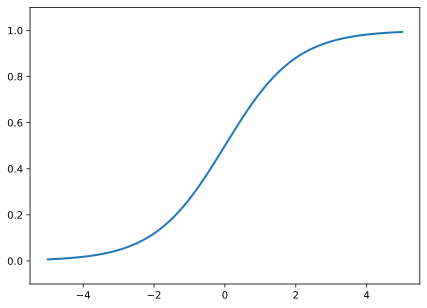

In [10]:
plot_logistic()


Funkcja logistyczna przekształca zbiór liczb rzeczywistych $\mathbb{R}$ w przedział otwarty $(0, 1)$.

Funkcja regresji logistycznej dla pojedynczego przykładu o cechach wyrażonych wektorem $x$:

$$h_\theta(x) = g(\theta^T \, x) = \dfrac{1}{1 + e^{-\theta^T x}}$$

Dla całej macierzy cech $X$:

$$h_\theta(X) = g(X \, \theta) = \dfrac{1}{1 + e^{-X \theta}}$$

In [11]:
def h(theta, X):
    """Funkcja regresji logistcznej"""
    return 1.0 / (1.0 + np.exp(-X * theta))


Funkcja kosztu dla regresji logistycznej:

$$J(\theta) = -\dfrac{1}{m} \left( \sum_{i=1}^{m} y^{(i)} \log h_\theta( x^{(i)} ) + \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta (x^{(i)}) \right) \right)$$

Gradient dla regresji logistycznej (wersja macierzowa):

$$\nabla J(\theta) = \frac{1}{|\vec y|} X^T \left( h_\theta(X) - \vec y \right)$$

(Jedyna różnica między gradientem dla regresji logistycznej a gradientem dla regresji liniowej to postać $h_\theta$).

In [12]:
def J(h, theta, X, y):
    """Funkcja kosztu dla regresji logistycznej"""
    m = len(y)
    h_val = h(theta, X)
    s1 = np.multiply(y, np.log(h_val))
    s2 = np.multiply((1 - y), np.log(1 - h_val))
    return -np.sum(s1 + s2, axis=0) / m


In [13]:
def dJ(h, theta, X, y):
    """Gradient dla regresji logistycznej"""
    return 1.0 / len(y) * (X.T * (h(theta, X) - y))


In [14]:
def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, max_steps=10000):
    """Metoda gradientu prostego dla regresji logistycznej"""
    curr_cost = fJ(h, theta, X, y)
    history = [[curr_cost, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        prev_cost = curr_cost
        curr_cost = fJ(h, theta, X, y)
        # kryteria stopu
        if abs(prev_cost - curr_cost) <= eps:
            break
        if len(history) > max_steps:
            break
        history.append([curr_cost, theta])
    return theta, history


In [15]:
# Uruchomienie metody gradientu prostego dla regresji logistycznej
theta_best, history = GD(
    h, J, dJ, theta_start, X, y, alpha=0.1, eps=10**-7, max_steps=1000
)
print(f"Koszt: {history[-1][0]}")
print(f"theta = {theta_best}")


Koszt: [[0.05755617]]
theta = [[ 5.02530461]
 [-1.99174803]]


In [16]:
def scalar_logistic_regression_function(theta, x):
    """Funkcja regresji logistycznej (wersja skalarna)"""
    return 1.0 / (1.0 + np.exp(-(theta.item(0) + theta.item(1) * x)))


def threshold_val(fig, x_thr):
    """Rysowanie progu"""
    ax = fig.axes[0]
    ax.plot(
        [x_thr, x_thr],
        [-1, 2],
        color="orange",
        linestyle="dashed",
        label="próg: $x={:.2F}$".format(x_thr),
    )


def logistic_regline(fig, theta, X):
    """Wykres krzywej regresji logistycznej"""
    ax = fig.axes[0]
    x0 = np.min(X[:, 1]) - 1.0
    x1 = np.max(X[:, 1]) + 1.0
    Arg = np.arange(x0, x1, 0.1)
    Val = scalar_logistic_regression_function(theta, Arg)
    ax.plot(Arg, Val, linewidth="2")


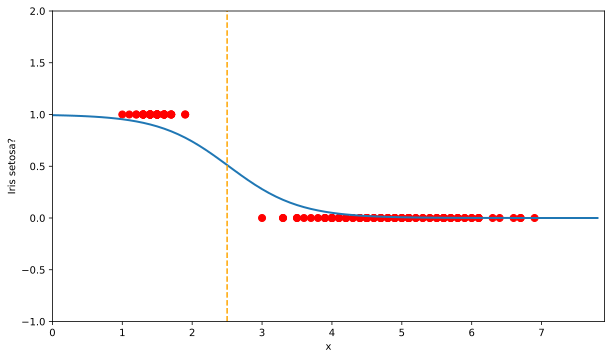

In [17]:
fig = regdots(X, y, xlabel="x", ylabel="Iris setosa?")
logistic_regline(fig, theta_best, X)
threshold_val(fig, 2.5)


Traktujemy wartość $h_\theta(x)$ jako prawdopodobieństwo zdefiniowane w następujący sposób:

$$ h_\theta(x) = P(y = 1 \, | \, x; \theta) $$

Jeżeli $h_\theta(x) > 0.5$, to dla takiego $x$ będziemy przewidywać wartość $y = 1$.
W przeciwnym wypadku uprzewidzimy $y = 0$.

Dlaczego możemy traktować wartość funkcji regresji logistycznej jako prawdopodobieństwo?

Można o tym poczytać w zewnętrznych źródłach, np. https://towardsdatascience.com/logit-of-logistic-regression-understanding-the-fundamentals-f384152a33d1

### Dwuklasowa regresja logistyczna: więcej cech

Jak postąpić, jeżeli będziemy mieli więcej niż jedną cechę $x$?

Weźmy teraz wszystkie cechy występujące w zbiorze *Iris*:
* długość płatków (`pl`, *petal length*)
* szerokość płatków (`pw`, *petal width*)
* długość działek kielicha (`sl`, *sepal length*)
* szerokość działek kielicha (`sw`, *sepal width*)

In [18]:
data_iris_setosa_multi = pandas.DataFrame()
for feature in ["pl", "pw", "sl", "sw"]:
    data_iris_setosa_multi[feature] = data_iris[feature]
data_iris_setosa_multi["Iris setosa?"] = data_iris["Gatunek"].apply(
    lambda x: 1 if x == "Iris-setosa" else 0
)
print(data_iris_setosa_multi[:6])


    pl   pw   sl   sw  Iris setosa?
0  1.4  0.2  5.2  3.4             1
1  1.5  0.4  5.1  3.7             1
2  5.6  2.4  6.7  3.1             0
3  5.1  2.0  6.5  3.2             0
4  4.5  1.7  4.9  2.5             0
5  5.1  1.6  6.0  2.7             0


In [19]:
# Przygotowanie danych
m, n_plus_1 = data_iris_setosa_multi.values.shape
n = n_plus_1 - 1
Xn = data_iris_setosa_multi.values[:, 0:n].reshape(m, n)

X = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m, n_plus_1)
y = np.matrix(data_iris_setosa_multi.values[:, n]).reshape(m, 1)

print(X[:6])
print(y[:6])


[[1.  1.4 0.2 5.2 3.4]
 [1.  1.5 0.4 5.1 3.7]
 [1.  5.6 2.4 6.7 3.1]
 [1.  5.1 2.  6.5 3.2]
 [1.  4.5 1.7 4.9 2.5]
 [1.  5.1 1.6 6.  2.7]]
[[1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [20]:
# Podział danych na zbiór trenujący i testowy
XTrain, XTest = X[:100], X[100:]
yTrain, yTest = y[:100], y[100:]

# Macierz parametrów początkowych
theta_start = np.ones(5).reshape(5, 1)


In [21]:
theta_best, history = GD(
    h, J, dJ, theta_start, XTrain, yTrain, alpha=0.1, eps=10**-7, max_steps=1000
)
print(f"Koszt: {history[-1][0]}")
print(f"theta = {theta_best}")


Koszt: [[0.006797]]
theta = [[ 1.11414027]
 [-2.89324615]
 [-0.66543637]
 [ 0.14887292]
 [ 2.13284493]]


### Funkcja decyzyjna regresji logistycznej

Funkcja decyzyjna mówi o tym, kiedy nasz algorytm będzie przewidywał $y = 1$, a kiedy $y = 0$:

$$ c(x) := \left\{ 
\begin{array}{ll}
1, & \mbox{gdy } P(y=1 \, | \, x; \theta) > 0.5 \\
0 & \mbox{w przeciwnym przypadku}
\end{array}\right.
$$

$$ P(y=1 \,| \, x; \theta) = h_\theta(x) $$

In [22]:
def classifyBi(theta, X):
    """Funkcja decyzyjna regresji logistycznej"""
    prob = h(theta, X).item()
    return (1, prob) if prob > 0.5 else (0, prob)


print(f"theta = {theta_best}")
print(f"x0 = {XTest[0]}")
print(f"h(x0) = {h(theta_best, XTest[0]).item()}")
print(f"c(x0) = {classifyBi(theta_best, XTest[0])}")


theta = [[ 1.11414027]
 [-2.89324615]
 [-0.66543637]
 [ 0.14887292]
 [ 2.13284493]]
x0 = [[1.  6.3 1.8 7.3 2.9]]
h(x0) = 1.606143695982487e-05
c(x0) = (0, 1.606143695982487e-05)


Obliczmy teraz skuteczność modelu (więcej na ten temat na następnym wykładzie, poświęconym metodom ewaluacji).

In [23]:
correct = 0
for i, rest in enumerate(yTest):
    cls, prob = classifyBi(theta_best, XTest[i])
    if i < 10:
        print(f"{yTest[i].item():1.0f} <=> {cls} -- prob: {prob:6.4f}")
    correct += cls == yTest[i].item()
accuracy = correct / len(XTest)

print(f"\nAccuracy: {accuracy}")


0 <=> 0 -- prob: 0.0000
1 <=> 1 -- prob: 0.9816
0 <=> 0 -- prob: 0.0001
0 <=> 0 -- prob: 0.0005
0 <=> 0 -- prob: 0.0001
1 <=> 1 -- prob: 0.9936
0 <=> 0 -- prob: 0.0059
0 <=> 0 -- prob: 0.0992
0 <=> 0 -- prob: 0.0001
0 <=> 0 -- prob: 0.0001

Accuracy: 1.0


## 4.2. Wieloklasowa regresja logistyczna

Przykład: wszystkie cechy ze zbioru *Iris*, wszystkie 3 klasy ze zbioru *Iris*.

In [24]:
import pandas

data_iris = pandas.read_csv("iris.csv")
data_iris[:6]


sl   sw   pl   pw          Gatunek
0  5.2  3.4  1.4  0.2      Iris-setosa
1  5.1  3.7  1.5  0.4      Iris-setosa
2  6.7  3.1  5.6  2.4   Iris-virginica
3  6.5  3.2  5.1  2.0   Iris-virginica
4  4.9  2.5  4.5  1.7   Iris-virginica
5  6.0  2.7  5.1  1.6  Iris-versicolor

In [25]:
# Przygotowanie danych

import numpy as np

features = ["sl", "sw", "pl", "pw"]
m = len(data_iris)
X = np.matrix(data_iris[features])
X0 = np.ones(m).reshape(m, 1)
X = np.hstack((X0, X))
y = np.matrix(data_iris[["Gatunek"]]).reshape(m, 1)

print("X = ", X[:4])
print("y = ", y[:4])


X =  [[1.  5.2 3.4 1.4 0.2]
 [1.  5.1 3.7 1.5 0.4]
 [1.  6.7 3.1 5.6 2.4]
 [1.  6.5 3.2 5.1 2. ]]
y =  [['Iris-setosa']
 ['Iris-setosa']
 ['Iris-virginica']
 ['Iris-virginica']]


Zamieńmy etykiety tekstowe w tablicy $y$ na wektory jednostkowe (*one-hot vectors*):

$$
\begin{array}{ccc}
\mbox{"Iris-setosa"}     & \mapsto & \left[ \begin{array}{ccc} 1 & 0 & 0 \\ \end{array} \right] \\
\mbox{"Iris-virginica"}  & \mapsto & \left[ \begin{array}{ccc} 0 & 1 & 0 \\ \end{array} \right] \\
\mbox{"Iris-versicolor"} & \mapsto & \left[ \begin{array}{ccc} 0 & 0 & 1 \\ \end{array} \right] \\
\end{array}
$$

Wówczas zamiast wektora $y$ otrzymamy macierz $Y$:

$$
y \; = \;
\left[
\begin{array}{c}
y^{(1)}     \\
y^{(2)}     \\
y^{(3)}     \\
y^{(4)}     \\
y^{(5)}     \\
\vdots      \\
\end{array}
\right]
\; = \;
\left[
\begin{array}{c}
\mbox{"Iris-setosa"}     \\
\mbox{"Iris-setosa"}     \\
\mbox{"Iris-virginica"}  \\
\mbox{"Iris-versicolor"} \\
\mbox{"Iris-virginica"}  \\
\vdots                   \\
\end{array}
\right]
\quad \mapsto \quad
Y \; = \;
\left[
\begin{array}{ccc}
1 & 0 & 0 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
0 & 1 & 0 \\
\vdots & \vdots & \vdots \\
\end{array}
\right]
$$

In [26]:
def mapY(y, cls):
    m = len(y)
    yBi = np.matrix(np.zeros(m)).reshape(m, 1)
    yBi[y == cls] = 1.0
    return yBi


def indicatorMatrix(y):
    classes = np.unique(y.tolist())
    m = len(y)
    k = len(classes)
    Y = np.matrix(np.zeros((m, k)))
    for i, cls in enumerate(classes):
        Y[:, i] = mapY(y, cls)
    return Y


# Macierz jednostkowa
Y = indicatorMatrix(y)


In [27]:
# Podział danych na zbiór trenujący i testowy
XTrain, XTest = X[:100], X[100:]
YTrain, YTest = Y[:100], Y[100:]

# Macierz parametrów początkowych - niech skłąda się z samych jedynek
theta_start = np.ones(5).reshape(5, 1)


Regresja logistyczna jest metodą rozwiązywania problemów klasyfikacji **dwuklasowej**.

Aby znaleźć rozwiązanie problemu klasyfikacji **wieloklasowej** metodą regresji logistycznej, trzeba przekształcić problem na zbiór problemów klasyfikacji dwuklasowej.

Alternatywnie, można użyć **wielomianowej regresji logistycznej** (zob. https://machinelearningmastery.com/multinomial-logistic-regression-with-python).

### Od regresji logistycznej dwuklasowej do wieloklasowej

* Irysy są przydzielone do trzech klas: _Iris-setosa_ (0), _Iris-versicolor_ (1), _Iris-virginica_ (2).
* Wiemy, jak stworzyć klasyfikatory dwuklasowe typu _Iris-setosa_ vs. _Nie-Iris-setosa_ (tzw. *one-vs-all*).
* Możemy stworzyć trzy klasyfikatory $h_{\theta_1}, h_{\theta_2}, h_{\theta_3}$ (otrzymując trzy zestawy parametrów $\theta$) i wybrać klasę o najwyższym prawdopodobieństwie.

Pomoże nam w tym funkcja *softmax*, która jest uogólnieniem funkcji logistycznej na większą liczbę wymiarów.

### Funkcja _softmax_

Odpowiednikiem funkcji logistycznej dla wieloklasowej regresji logistycznej jest funkcja $\mathrm{softmax}$:

$$ \textrm{softmax} \colon \mathbb{R}^k \to [0,1]^k $$

$$ \textrm{softmax}(z_1,z_2,\dots,z_k) = \left( \dfrac{e^{z_1}}{\sum_{i=1}^{k}e^{z_i}}, \dfrac{e^{z_2}}{\sum_{i=1}^{k}e^{z_i}}, \ldots, \dfrac{e^{z_k}}{\sum_{i=1}^{k}e^{z_i}} \right) $$

$$ \textrm{softmax}( \left[ \begin{array}{c} \theta_1^T x \\ \theta_2^T x \\ \vdots \\ \theta_k^T x \end{array} \right] ) = \left[ \begin{array}{c} P(y=1 \, | \, x;\theta_1,\ldots,\theta_k) \\ P(y=2 \, | \, x;\theta_1,\ldots,\theta_k) \\ \vdots \\ P(y=k \, | \, x;\theta_1,\ldots,\theta_k) \end{array} \right] $$

In [28]:
def softmax(X):
    """Funkcja softmax (wersja macierzowa)"""
    return np.exp(X) / np.sum(np.exp(X))


Wartości funkcji $\mathrm{softmax}$ sumują się do 1:

In [29]:
Z = np.matrix([[2.1, 0.5, 0.8, 0.9, 3.2]])
P = softmax(Z)
print(np.sum(P))


0.9999999999999999


In [30]:
def multiple_binary_classifiers(X, Y):
    n = X.shape[1]
    thetas = []
    # Dla każdej klasy wytrenujmy osobny klasyfikator dwuklasowy.
    for c in range(Y.shape[1]):
        YBi = Y[:, c]
        theta = np.matrix(np.random.random(n)).reshape(n, 1)
        # Macierz parametrów theta obliczona dla każdej klasy osobno.
        theta_best, history = GD(h, J, dJ, theta, X, YBi, alpha=0.1, eps=10**-4)
        thetas.append(theta_best)
    return thetas


In [31]:
# Macierze theta dla każdej klasy
thetas = multiple_binary_classifiers(XTrain, YTrain)
for c, theta in enumerate(thetas):
    print(f"Otrzymana macierz parametrów theta dla klasy {c}:\n", theta, "\n")


Otrzymana macierz parametrów theta dla klasy 0:
 [[ 0.44809895]
 [-0.02470655]
 [ 1.73058264]
 [-1.97727025]
 [-0.3624556 ]] 

Otrzymana macierz parametrów theta dla klasy 1:
 [[ 0.5642055 ]
 [ 0.11085065]
 [-1.01510744]
 [ 0.55275035]
 [-0.70237456]] 

Otrzymana macierz parametrów theta dla klasy 2:
 [[-0.44893077]
 [-1.60497843]
 [-1.86196767]
 [ 2.36049057]
 [ 2.5959696 ]] 



### Funkcja decyzyjna wieloklasowej regresji logistycznej

$$ c = \mathop{\textrm{arg}\,\textrm{max}}_{i \in \{1, \ldots ,k\}} P(y=i|x;\theta_1,\ldots,\theta_k) $$

In [32]:
def classify(thetas, X, debug=False):
    regs = np.array([(X * theta).item() for theta in thetas])
    if debug:
        print("Po zastosowaniu regresji: ", regs)
    probs = softmax(regs)
    if debug:
        print("Otrzymane prawdopodobieństwa: ", np.around(probs, decimals=3))
    result = np.argmax(probs)
    if debug:
        print("Wybrana klasa: ", result)
    return result


In [33]:
for i in range(4):
    print(f"Dla x = {XTest[i]}:")
    YPredicted = classify(thetas, XTest[i], debug=True)
    print(f"Obliczone y = {YPredicted}")
    print(f"Oczekiwane y = {np.argmax(YTest[i])}")
    print() 


Dla x = [[1.  7.3 2.9 6.3 1.8]]:
Po zastosowaniu regresji:  [-7.82279188  0.64765672  1.97885627]
Otrzymane prawdopodobieństwa:  [0.    0.209 0.791]
Wybrana klasa:  2
Obliczone y = 2
Oczekiwane y = 2

Dla x = [[1.  4.8 3.  1.4 0.3]]:
Po zastosowaniu regresji:  [ 2.6443404  -1.38589555 -9.65525259]
Otrzymane prawdopodobieństwa:  [0.983 0.017 0.   ]
Wybrana klasa:  0
Obliczone y = 0
Oczekiwane y = 0

Dla x = [[1.  7.1 3.  5.9 2.1]]:
Po zastosowaniu regresji:  [-6.96262088  0.09216334  1.94824984]
Otrzymane prawdopodobieństwa:  [0.    0.135 0.865]
Wybrana klasa:  2
Obliczone y = 2
Oczekiwane y = 2

Dla x = [[1.  5.9 3.  5.1 1.8]]:
Po zastosowaniu regresji:  [-5.24242014 -0.27234536  1.20704063]
Otrzymane prawdopodobieństwa:  [0.001 0.185 0.813]
Wybrana klasa:  2
Obliczone y = 2
Oczekiwane y = 2

